# Definición del problema a resolver
• ¿Cuál es el problema?
- ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?

- ¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?

- ¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?

- Dado un accidente, ¿se puede generar un modelo que prediga si habrá fallecimientos o no? ¿Si se va a necesitar tratamiento médico o no? Las aseguradoras tienen que inmovilizar capital para pagar estas casuísticas. 

• Acción que buscamos hacer para solucionar el problema

• ¿Cuáles son las variables disponibles?

• ¿En qué momento se va a implantar el modelo? ¿Qué variables hay disponibles en
el momento de llamada al modelo?

• ¿Cómo se va a validar el modelo?


Aquí hay que redactar una introducción explicando el caso y toda la parafernalia...

# Exploración general / inicial
• Dimensiones de la tabla y variables

• Analizar si las variables estarán disponibles en el momento de la llamada al modelo
(sino se estaría introduciendo información a futuro en el modelo)

• Exploración de la variable objetivo

• Rápido análisis de valores nulos

• Se explora el número de variables numéricas y categóricas y se decide qué proceso
realizar para tratarlas

• Transformaciones iniciales de algunas variables: formato de fechas, eliminar
espacios de una variable string, etc

• Analizar la variable objetivo: aislándola de las demás variables (quizás, a pesar de
no tener en cuenta las variables tenemos que sacar un 80% de accuracy.

In [ ]:
#Librerías
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import plotly.express as px
import scipy.stats as ss

In [ ]:
#Importamos los datos
df = pd.read_csv("../data/NCDB_1999_to_2014.csv")

In [ ]:
print("El dataset está compuesto por", len(df.index), "filas y", len(df.columns), "columnas")
df.head(5)

In [ ]:
# Cambio de nombre de las variables
new_names = ["year", "month", "weekday", "hour", "fatality", "vehicles_involved", "crash_type", "crash_place", "crash_weather",
"surface_state", "road_slope", "traffic_state", "vehicle_id", "vehicle_type", "vehicle_year", "passenger_id", "passenger_sex",
"passenger_age", "passenger_role", "passenger_fatality", "passenger_safety", "passenger_type"]

print(len(new_names) == len(df.columns))

df.columns = new_names

In [ ]:
# Comprobamos el tipo de las variables, la mayoría son categóricas salvo fechas y variable objetivo(booleana)
# Algunas variables las podemos convertir en numéricas. ej. passenger_age
print(df.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index())
df.dtypes 

# Variables futuras y duplicados

El dataset contiene variables que no están disponible en el momento de la colisión y por tanto escapan al objetivo de nuestro ánalisis y otras que directamente no son de útilidad como IDs. También debemos prescindir de registros duplicados antes de eliminar los IDs

In [ ]:
print(df.shape)
df = df.drop_duplicates().drop(["passenger_id","passenger_fatality", "vehicle_id"], axis=1)
df.shape

# Variable Objetivo

In [ ]:
# Recodeado de la variable objetivo
# Antes: 1-fatality 2-no fatality
# Después: 1-fatality 0-no fatality
df['fatality'] = df['fatality'].replace({2:0})

In [ ]:
#Ponemos la variable objetivo a la derecha del dataframe
new_columns = list(df.columns[0:4]) + list(df.columns[5:]) + list(df.columns[4:5])
df = df[new_columns]

In [ ]:
# Plot variable 'fatality. Podemos ver que el dataset está muy desbalanceado
fatality_per = df['fatality'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
fatality_count = df['fatality'].value_counts().reset_index()
fataity_merge= pd.merge(fatality_per, fatality_count, on=['index'], how='inner')
fig = px.histogram(fataity_merge, x="index", y=['percent'], labels={'index':'fatality'})
fig.show()

# Valores Nulos

En el diccionario de datos encontramos varios tipos de datos ausentes.  En elPrincipalmente U, UU y UUUU que son datos estirctamente desconocidos.  
Luego tenemos los X, XX y XXXX que son no proporcionados por la jurisdicción, no encontramos ningun registro con esta etiqueta en los datos.  
Por otro lado tenemos los N, NN y NNNN que hacen referencia a que la variable no aplica al registro concreto. Por ejemplo en los registros creados para coches aparcados y peatones.  Más adelante decidiremos que hacer con estos registros.  
Por último los Q, QQ, QQQQ que son otras opciones que no aparecen en las posibles y tampoco deben ser tratados como nulos.

In [ ]:
# Remplazamos U, UU y UUUU por NAs
df = df.replace({"U": np.nan, "UU": np.nan, "UUUU": np.nan})

In [ ]:
# Análisis Nulos
nulos_col = pd.merge(df.isnull().sum().sort_values().to_frame('missing_value').reset_index(),
         df.dtypes.to_frame('feature_type').reset_index(),
         on = 'index',
         how = 'inner')
nulos_col['columns_percentage'] = nulos_col['missing_value']/df.shape[0]
nulos_col.sort_values(['missing_value', 'feature_type', 'columns_percentage'], ascending=False)

In [ ]:
null_rows = df.isnull().sum(axis=1).sort_values(ascending=False)
nulos_filas = pd.DataFrame(null_rows, columns=['nulos_filas'])  
nulos_filas['target'] = df['fatality'].copy()
nulos_filas['porcentaje_filas']= nulos_filas['nulos_filas']/df.shape[1]
nulos_filas

In [ ]:
# Podemos ver como la mayoría de filas con mas de 40% NAs no son fatalities
# En una proporción bastante menor a la que encontramos en el conjunto de datos
NA_0 = nulos_filas.target[(nulos_filas.porcentaje_filas>=0.40) & (nulos_filas.target==0)].count()
NA_1 = nulos_filas.target[(nulos_filas.porcentaje_filas>=0.40) & (nulos_filas.target==1)].count()
print(NA_0, NA_1)
NA_1/NA_0

Tras hacer el analisis de los nulos por filas y por columnas. Procedemos a eliminar los registros con más nulos. En cuanto a columnas mantenemos todas puesto que solo una de ellas supera ligeramente el 10% de nulos una cantidad dentro de un treshold razonable y puede ser una variable de interés para el modelo. En cuanto a las filas vamos a eliminar todos los registros que contengan más de un 40% de nulos, es decir, 8 o más variables con valor nulo en un solo registro.

In [ ]:
#Eliminando los registros con >40% nulos
nulos_40 = list(nulos_filas.index[nulos_filas.porcentaje_filas>=0.40])
df = df.loc[set(df.index)-set(nulos_40)].reset_index()

In [ ]:
#TODO: ¿Que hacemos con dummies NN? 
print(df[(df['passenger_age']=='NN') & (df['fatality']==0)].shape)
df[(df['passenger_age']=='NN') & (df['fatality']==1)].shape

# Transformación Básica de algunas variables

In [ ]:
# Cambio de la variable vehicle_year a años de antigüedad y eliminamos vehicle_year
# Cambiamos passenger_age y vehicles_involved a númericas ninguna de las dos tiene NAs. 
# Sin embargo, passenger_age tiene valores NN para transformar la variable los haremos NA con 'coerce'
df['vehicle_year'] = pd.to_numeric(df.year - pd.to_numeric(df.vehicle_year, errors= "coerce"))
df = df.rename(columns={"vehicle_year": 'vehicle_age'})
df['passenger_age'] = pd.to_numeric(df['passenger_age'],"coerce")
df['vehicles_involved'] = pd.to_numeric(df['vehicles_involved'],"ignore")

In [ ]:
def dame_variables_categoricas(dataset=None):
    '''
    ----------------------------------------------------------------------------------------------------------
    Función dame_variables_categoricas:
    ----------------------------------------------------------------------------------------------------------
        -Descripción: Función que recibe un dataset y devuelve una lista con los nombres de las 
        variables categóricas
        -Inputs: 
            -- dataset: Pandas dataframe que contiene los datos
        -Return:
            -- lista_variables_categoricas: lista con los nombres de las variables categóricas del
            dataset de entrada con menos de 100 valores diferentes
            -- 1: la ejecución es incorrecta
    '''
    if dataset is None:
        print(u'\nFaltan argumentos por pasar a la función')
        return 1
    lista_variables_categoricas = []
    other = []
    for i in dataset.columns:
        if (dataset[i].dtype == object):
                lista_variables_categoricas.append(i)
        else:
            other.append(i)

    return lista_variables_categoricas, other


In [ ]:
dame_variables_categoricas(df)
lista_categoricas, lista_numericas = dame_variables_categoricas(df)

In [ ]:
print(lista_categoricas, lista_numericas)

# En progreso (ignorar)

In [ ]:
# Columna MONTH
print(df["month"].unique())
df["month"] = np.int8(df["month"].replace({"01": 1, "02": 2, "11": 11, "12" : 12}))
df = df[df["month"] != 0]
df["month"].unique()
month_analysis = df.groupby(["month", "fatality"]).size()

for i in range(1, 1+ np.int8(len(month_analysis)/2)):
    print("El porcentaje de fatalities/accidente para el mes",
    i ,"es del",round(month_analysis[i][1]/month_analysis[i].sum()*100, 3), "%")
month_analysis[2]
### Dividiremos la variable month en cuatro valores distintos, representando los distintos trimestres del año (Q1-4).
#### La razón para esto es la existencia de un patrón estacional en el que los distintos trimestres (o estaciones del año) tienen valores similares a la hora de relacionarse con la variable objetivo $fatality$
# df["month"] = df["month"].replace({1:1, 2:1, 3:1, 4:2, 5:2, 6:2, 7:3, 8:3, 9:3, 10:4, 11:4, 12:4})
## Columna Weekday
print(df["weekday"].unique())
df["weekday"] = np.int8(df["weekday"].replace({"7": 7, "1": 1, "2": 2, "3" : 3, "4":4, "5":5, "6":6}))
print(df["weekday"].unique())
#Las filas con NA en weekday (valor 0 para el día de la semana) son un número mínimo en comparación con el tamaño del data-set así que nos deshacemos de ellas
# Nos deshacemos de esas filas
df = df[df["weekday"] != 0]
weekday_analysis = df.groupby(["weekday", "fatality"]).size()

for i in range(1, 1+ np.int8(len(weekday_analysis)/2)):
    print("El porcentaje de fatalities/accidente para el día de la semana",
    i ,"es del",round(weekday_analysis[i][1]/weekday_analysis[i].sum()*100, 3), "%")
## Columna $hour$
### Opción 1: https://towardsdatascience.com/how-to-handle-cyclical-data-in-machine-learning-3e0336f7f97c
### Opción 2: Identificar distintos "tramos" de similar influencia en $fatalities$ y luego hotencodearlo. Habría que hacerlo por tramos para reducir, ya que 24 variables para la hora quizás sean demasiadas
df = df[df["hour"].notnull()]
df["hour"] = df["hour"].astype("int8")
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(8,6), dpi=80)


hour_analysis = df.groupby(["hour", "fatality"]).size()
hour_values = list()

for i in range(0, int(len(hour_analysis)/2)):
    print("El porcentaje de fatalities/accidente para la hora",
    i ,"es del",round(hour_analysis[i][1]/hour_analysis[i].sum()*100, 3), "%")
    hour_values.append(hour_analysis[i][1]/hour_analysis[i].sum()*100)

hour_values = pd.DataFrame(hour_values)
hour_values.T.iloc[0].plot()

# He pensado en unificar las columnas de fecha pero he observado que la proporción de muertes / heridos es bastante diferente según el día de la semana (e imagino que también por la hora)

print(df.fatality.value_counts() / len(df.index) * 100)

df.loc[df["weekday"] == 6].fatality.value_counts() / len(df.loc[df["weekday"] == 6].index) * 100


# Gráficos

## 1. Colisiones y Tiempo

### 1.1. Observación del periodo completo

In [ ]:
#Cambio df por df_ts para no añadir columnas al df sobre el que vamos a trabajar?
df_ts = pd.DataFrame()
df_ts["date"] = pd.DatetimeIndex(df["year"].map(str) + "-" + df["month"].map(str))
df_ts["fatal"] = np.where(df["fatality"]==1, 1, 0)
df_ts["non_fatal"] = np.where(df["fatality"]==0, 1, 0)

In [ ]:
time_collision_both = df_ts.groupby('date')["fatal","non_fatal"].sum()
plot = time_collision_both.plot(figsize = (15,5), title = "Deadly colissions over time")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

In [ ]:
time_collision_fatal = df_ts.groupby('date')["fatal"].sum()
plot = time_collision_fatal.plot(figsize = (15,5), title = "Deadly colissions over time")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

In [ ]:
time_collision_nonfatal = df_ts.groupby('date')["non_fatal"].sum()
plot = time_collision_nonfatal.plot(figsize = (15,5), title = "Deadly colissions over time", color = "orange")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

### 1.2. Observación reducida a los últimos 5 años

In [ ]:
#TODO: Filtrar ultimos 5 años
#df_reduced = df.loc[df["date"] >= "2009"]

plot = time_collision_fatal.plot(figsize = (15,5), title = "Deadly colissions over time")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

In [ ]:
plot = time_collision_nonfatal.plot(figsize = (15,5), title = "Deadly colissions over time", color="orange")
plot.set_xlabel("Year")
plot.set_ylabel("Number of deadly colissions")

### 1.3 Correlación entre los valores de la variable objetivo

In [ ]:
plt.figure(figsize=(15,5))
for c in time_collision_both.columns:
    autocorrelation_plot(time_collision_both[c][-60:],label=c);

In [ ]:
plt.figure(figsize=(15,5))
sns.regplot('fatal', 'non_fatal', data=time_collision_both);

In [ ]:
corr = time_collision_both.corr()
print("La correlación entre los accidentes fatales y no fatales es de", str(round(corr["fatal"]["non_fatal"], 3)))
corr

## 2. Análisis de los días de la semana y las horas

### 2.1. Días de la semana

In [ ]:
index = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday_analysis = df.groupby("weekday")["fatality"].count()
weekday_analysis.index = index
plt.figure(figsize=(15,5))
plot = weekday_analysis.plot(kind="bar", title = "Collisions by week day")

In [ ]:
weekday_analysis = df.groupby(["weekday", "fatality"]).size()
serie_weekday = list()
for i in range(1, 8):
    serie_weekday.append(weekday_analysis[i][1] / weekday_analysis[i].sum() * 100)

weekday_analysis_serie = pd.Series(serie_weekday, index = index)
plt.figure(figsize=(15,5))
plot = weekday_analysis_serie.plot(kind="bar", title = "Percentage of deadly collisions by week day")

### 2.2. Horas del día

In [ ]:
index = np.arange(0,24)
hour_analysis = df.groupby("hour")["fatality"].count()
hour_analysis.index = index
plt.figure(figsize=(15,5))
plot = hour_analysis.plot(kind="bar", title = "Collisions by hour of the day")

In [ ]:
hour_analysis = df.groupby(["hour", "fatality"]).size()
serie_weekday = list()
for i in range(0, 24):
    serie_weekday.append(hour_analysis[i][1] / hour_analysis[i].sum() * 100)

hour_analysis = pd.Series(serie_weekday, index = index)
plt.figure(figsize=(15,5))
plot = hour_analysis.plot(kind="bar", title = "Percentage of deadly collisions by hour of the day")

## 3. Colisiones y Carretera

### 3.1. Road Configuration

In [ ]:
#FIXME: not working 
def plot_cat(col_name):
    ax2 = plt.plot(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    data = df.groupby(col_name)['fatality'].value_counts(normalize=True).to_frame('proportion').reset_index() 
    data.columns = [col_name, 'fatality', 'proportion']
    #sns.barplot(x = col_name, y = 'proportion', hue= 'target', data = data, saturation=1, ax=ax2)
    sns.barplot(x = col_name, y = 'proportion', hue= 'fatality', data = data, saturation=1, ax=ax2)
    ax2.set_ylabel('fatality'+' fraction')
    ax2.set_title('fatality')
    plt.xticks(rotation = 90)
    ax2.set_xlabel(col_name)
    plt.tight_layout()

data = df.groupby('crash_place')['fatality'].value_counts(normalize=True).to_frame('proportion').reset_index() 
data.columns = ['crash_place', 'fatality', 'proportion']

#plot_cat("crash_place")

In [ ]:
index = np.arange(1,12)
place_analysis = df.groupby("crash_place")["fatality"].count()
# place_analysis.index = index
plt.figure(figsize=(15,5))
plot = place_analysis.plot(kind="bar", title = "Collisions by Crash Place")
place_type = ['Mid-block','At an intersection','Intersection with parking lot entrance/exit',
            'Railroad crossing','Bridge','Tunnel','Passing or climbing lane',
             'Ramp','Traffic circle','Highway express lane', 'Other']

plt.xticks(np.arange(0,11),place_type,rotation=45, size='small' ); 

In [ ]:
#TODO: titulo de cada plot: Colisiones fatales por lugar
#FIXME: Es un porcentaje sobre el total de accidentes por categoría ¿Y porcentaje sobre el total de muertes?

place_analysis = df.groupby(["crash_place", "fatality"]).size()
serie_place = list()

for i in range(0, 11):
    serie_place.append(place_analysis[:,1][i] / (place_analysis[:,1][i] +(place_analysis[:,0][i])) * 100)

place_analysis = pd.Series(serie_place, index = range(0,11))
plt.figure(figsize=(15,5))
plot = place_analysis.plot(kind="bar", title = "Percentage of deadly collisions by place")
plt.xticks(np.arange(0,11),place_type,rotation=45, size='small' ); 

### 3.2. Condiciones Climáticas

In [ ]:
df['crash_weather'].unique()
## Valor Q means "Other"

In [ ]:
index = np.arange(0,8)
weather_analysis = df.groupby("crash_weather")["fatality"].count()
weather_analysis.index = index

plt.figure(figsize=(15,5))
plot = weather_analysis.plot(kind="bar", title = "Collisions by Weather Condition")
weather_type = ['Clear','Cloudy','Rain','Snow','Freezing Rain,Hail',
                'Low Visibility','Strong Wind','Other']

plt.xticks(np.arange(0,8),weather_type,rotation=45, size='small' ); 

In [ ]:
#TODO: titulo de cada plot: Colisiones fatales por lugar
#FIXME: Es un porcentaje sobre el total de accidentes por categoría ¿Y porcentaje sobre el total de muertes?

weather_analysis = df.groupby(["crash_weather", "fatality"]).size()
serie_weather = list()

for i in range(0, 8):
    serie_weather.append(weather_analysis[:,1][i] / (weather_analysis[:,1][i] +(weather_analysis[:,0][i])) * 100)

weather_analysis = pd.Series(serie_weather, index = range(0,8))
plt.figure(figsize=(15,5))
plot = weather_analysis.plot(kind="bar", title = "Percentage of deadly collisions by place")
plt.xticks(np.arange(0,8),weather_type,rotation=45, size='small' ); 

# Funciones

In [ ]:
### Función mortalidad (% / 100 Accidentes)

def mortalidad(columna, tipos, titulo):
    analysis = df.groupby([columna, "fatality"]).size()
    serie = list()

    for i in range(0, np.int8(len(analysis)/2)):
        serie.append(analysis[:,1][i] / (analysis[:,1][i] + (analysis[:,0][i])) * 100)
    
    analysis = pd.Series(serie, index = range(0, np.int8(len(analysis)/2)))
    plt.figure(figsize=(15,5))
    plot = analysis.plot(kind="bar", title = titulo)
    plot.set_xticklabels(tipos, rotation = 45)

In [ ]:
tipos = ['Clear','Cloudy','Rain','Snow','Freezing Rain,Hail',
                'Low Visibility','Strong Wind','Other']
mortalidad("crash_weather", tipos, "Titulo de prueba")

In [ ]:
### Función frecuencia absoluta
def frecuencia(columna, tipos, titulo):
    analysis = df.groupby(columna)["fatality"].count()
    plt.figure(figsize=(15,5))
    plot = analysis.plot(kind="bar", title=titulo)
    plot.set_xticklabels(tipos, rotation = 45)

In [ ]:
frecuencia("crash_weather", tipos, "Título de prueba")

In [173]:
def mortalidadtotal(columna, tipos, titulo):
    analysis = df.groupby(columna)["fatality"].sum() / df["fatality"].sum() * 100
    plt.figure(figsize=(15,5))
    plot = analysis.plot(kind="bar", title=titulo)
    plot.set_xticklabels(tipos, rotation = 45)


   # df.groupby("crash_weather")["fatality"].sum() / df["fatality"].sum() * 100

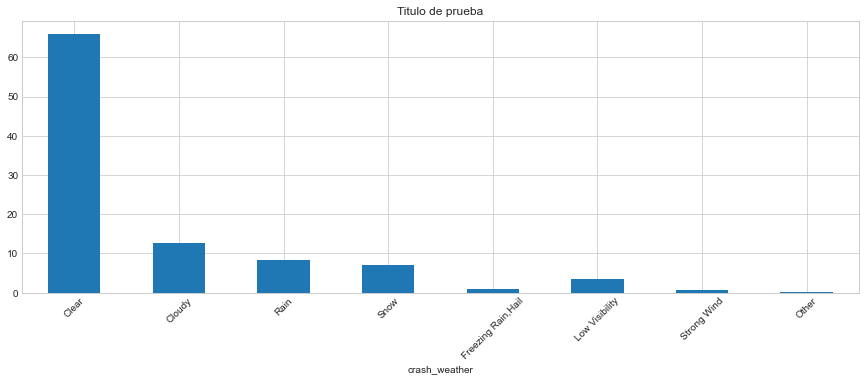

In [177]:
mortalidadtotal("crash_weather", tipos, ("Titulo de prueba"))

# Cramer Variables Categoricas

In [ ]:
def cramers_corrected_stat(x,y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

In [ ]:
def cramers_fatality(y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(df['fatality'].value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(df['fatality'], y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

In [ ]:
#TODO
#Quizá añadir despues de cada gráfico por variable
#Entre 0 y 1. Cuanto mayor, mayor relación entre variables
cramers_corrected_stat(df['fatality'], df['crash_place'])

In [ ]:
cramers_corrected_stat(df['fatality'], df['passenger_safety']) 

In [ ]:
cramers_corrected_stat(df['fatality'], df['crash_weather'])

In [ ]:
#FIXME
df[lista_categoricas].apply(cramers_fatality, axis = 1)

In [ ]:
#TODO
#Gráficos con llamada a función  
#Resolver tema NNs -- Fixed
#V de Cramer 
#Para modelo eliminar registros que no sean de conductor y tal vez peatón? Posible overfittng con muchas personas para un solo accidente

In [ ]:
df #sobran date, fatal y non_fatal.    
